# Exploring HAMSR data

Load necessary modules.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import glob
# trick to read function in a separate file
import sys
sys.path.append('/glade/u/home/rberrios/python/PRECIP/')
from defineColormaps import *

%matplotlib inline
import matplotlib.pyplot as plt
#increase font size
plt.rcParams.update({'font.size': 14})

Set the time periods to be plotted.

In [2]:
file_date = '20220914'           #which date to create the HAMSR plot for
start_time0 = '20220914,123500'  #start date,time for the HAMSR plot
end_time0 = '20220914,133500'    #end date,time for the HAMSR plot

start_time = datetime.datetime.strptime(start_time0, '%Y%m%d,%H%M%S')
end_time = datetime.datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

# Calculate the length of the segment in time, to scale out the figure
segDuration = int((end_time - start_time).total_seconds())
figWidth = int(segDuration / 240)
figWidth

15

Define paths to data.

In [3]:
# location of HAMSR files
pth = '/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/'
hamsr_folder = pth+'HAMSR/'

# location of final Dropsonde CSVs
drop_folder = "./CPEXCV-dropsonde_DC8_" + file_date + "_R0/"

Get list of HAMSR data files

In [4]:
def find_hamsr_files(start_time, end_time):
    #find the files in the hamsr folder
    hamsr_files = [f for f in sorted(glob.glob(hamsr_folder+'/CPEXCV-HAMSR-data_DC8_*nc', recursive=True))]
    first_file_index = None       
    for i, x in enumerate(hamsr_files):  #sorted() makes sure the code goes through the files in alphabetical (chronological) order 
        file_start_time = datetime.datetime.strptime(x[94:104], '%Y%m%d%H')
        file_end_time = datetime.datetime.strptime(x[94:104]+'59', '%Y%m%d%H%M')
    
        if start_time <= file_start_time:  #if start_time is before the APR file start time and not within any previous APR file's time ranges
            first_file_index = i
            break
        elif (start_time >= file_start_time and (start_time < file_end_time)):
            first_file_index = i
            break
        else:
            continue
    if first_file_index == None:
        sys.exit('Requested start_time is beyond all available APR files')
        
    #find the ending APR file in apr_folder
    last_file_index = None       
    for i, x in enumerate(hamsr_files):  #sorted() makes sure the code goes through the files in alphabetical (chronological) order 
    
        file_start_time = datetime.datetime.strptime(x[94:104], '%Y%m%d%H')
        file_end_time = datetime.datetime.strptime(x[94:104]+'59', '%Y%m%d%H%M')
    
        if end_time <= file_start_time:  #if start_time is before the APR file start time and not within any previous APR file's time ranges
            last_file_index = i - 1
            break
        elif (end_time > file_start_time) and (end_time <= file_end_time):
            last_file_index = i
            break
        else:
            continue
    if last_file_index == None:  #the end_time is after all available APR files
        last_file_index = len(sorted(os.listdir(apr_folder))) - 1  #the last available APR file's index
    if last_file_index == -1:
        sys.exit('Requested end_time is before all available APR files')
    
    # [f for f in sorted(glob.glob(drop_folder+'/CPEXCV-dropsonde*ict', recursive=True))]
    hamsr_file_list = hamsr_files[first_file_index:last_file_index + 1]
    return hamsr_file_list
    
hamsr_file_list = find_hamsr_files(start_time, end_time)

Now get list of dropsonde files

In [5]:
def find_dropsonde_files(start_time, end_time):
    # find the starting dropsonde file in drop_folder
    drop_files = [
        f for f in sorted(glob.glob(drop_folder + "/CPEXCV-dropsonde*ict", recursive=True))
    ]
    first_file_index = None
    for i, x in enumerate(
        drop_files
    ):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
        file_start_time = datetime.datetime.strptime(x[56:70], "%Y%m%d%H%M%S")
        file_end_time = file_start_time  # hack; dropsonde start and final time assumed to be the same for simplicity
    
        if (
            start_time <= file_start_time
        ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
            first_file_index = i
            break
        elif start_time >= file_start_time and (start_time < file_end_time):
            first_file_index = i
            break
        else:
            continue
    if first_file_index == None:
        sys.exit("Requested start_time is beyond all available APR files")
    
    # find the ending APR file in apr_folder
    last_file_index = None
    for i, x in enumerate(
        drop_files
    ):  # sorted() makes sure the code goes through the files in alphabetical (chronological) order
        file_start_time = datetime.datetime.strptime(x[56:70], "%Y%m%d%H%M%S")
        file_end_time = file_start_time  # hack; dropsonde start and final time assumed to be the same for simplicity
    
        if (
            end_time <= file_start_time
        ):  # if start_time is before the APR file start time and not within any previous APR file's time ranges
            last_file_index = i - 1
            break
        elif (end_time > file_start_time) and (end_time <= file_end_time):
            last_file_index = i
            break
        else:
            continue
    if last_file_index == None:  # the end_time is after all available APR files
        last_file_index = (
            len(sorted(os.listdir(apr_folder))) - 1
        )  # the last available APR file's index
    if last_file_index == -1:
        sys.exit("Requested end_time is before all available APR files")
    
    # [f for f in sorted(glob.glob(drop_folder+'/CPEXCV-dropsonde*ict', recursive=True))]
    drop_file_list = drop_files[first_file_index : last_file_index + 1]
    return drop_file_list
    
drop_file_list = find_dropsonde_files(start_time, end_time)

Define a function that computes geometric height from pressure and temperature.

In [6]:
def calculate_geometric_height(temp_da, pres_da, vertical_dim='level', surface_height=0.0):
    """
    Calculates geometric height using the hydrostatic balance assumption for 2D DataArrays.

    This function assumes that one of the dimensions ('lines' or 'columns') represents
    the vertical profile (e.g., pressure levels), and the other represents a horizontal
    or spatial dimension. The hydrostatic integration is performed along the
    'vertical_dim' for each slice of the 'horizontal_dim'.

    Args:
        temp_da (xr.DataArray): Temperature data array (in Kelvin).
                                 Assumed to have 'lines' and 'columns' dimensions.
        pres_da (xr.DataArray): Pressure data array (in Pascals).
                                 Assumed to have 'lines' and 'columns' dimensions.
        vertical_dim (str, optional): The dimension along which the vertical profile
                                      (e.g., pressure levels) exists. Defaults to 'level'.
        surface_height (float, optional): The geometric height at the lowest
                                          pressure level for each vertical profile.
                                          Defaults to 0.0 meters.

    Returns:
        xr.DataArray: Geometric height data array (in meters) with the same
                      dimensions and coordinates as the input temperature and pressure.
    """
    # Define physical constants
    R_d = 287.058  # Specific gas constant for dry air (J kg^-1 K^-1)
    g_0 = 9.80665  # Standard acceleration due to gravity (m s^-2)

    # Validate dimensions
    if not (vertical_dim in temp_da.dims and vertical_dim in pres_da.dims):
        raise ValueError(f"Input DataArrays must contain '{vertical_dim}' dimension.")
    if temp_da.shape != pres_da.shape:
        raise ValueError("Input DataArrays for temperature and pressure must have the same shape.")

    # Identify the other (horizontal) dimension
    other_dims = [d for d in temp_da.dims if d != vertical_dim]
    if len(other_dims) != 1:
        raise ValueError(f"Expected exactly one non-{vertical_dim} dimension (the horizontal dimension).")
    horizontal_dim = other_dims[0]

    # Initialize height_da with the same dimensions and coordinates as temp_da
    height_da = xr.zeros_like(temp_da)

    # Iterate over each 'horizontal_dim' slice (e.g., each 'column')
    for idx_horiz in range(len(temp_da[horizontal_dim])):
        # Extract 1D profiles for the current horizontal slice as numpy arrays
        # .values converts the xarray.DataArray slice into a numpy array
        temp_profile_orig = temp_da.isel({horizontal_dim: idx_horiz}).values
        pres_profile_orig = pres_da.isel({horizontal_dim: idx_horiz}).values

        # Store original vertical coordinates for mapping back later
        vertical_coords_orig = temp_da[vertical_dim].values

        # Get indices that would sort pressure in descending order.
        # np.argsort(-pres_profile_orig) sorts from highest pressure to lowest.
        sort_indices = np.argsort(-pres_profile_orig)

        # Apply sorting to both temperature and pressure profiles
        temp_profile_sorted = temp_profile_orig[sort_indices]
        pres_profile_sorted = pres_profile_orig[sort_indices]

        num_levels = len(pres_profile_sorted)
        column_heights_sorted = np.zeros(num_levels)
        # The height at the lowest pressure level (which is the first after sorting)
        column_heights_sorted[0] = surface_height

        # Iterate through sorted pressure levels from bottom (highest pressure) up (lowest pressure)
        for i in range(num_levels - 1):
            P1 = pres_profile_sorted[i]     # Pressure at current level (lower in the layer)
            P2 = pres_profile_sorted[i+1]   # Pressure at next level (upper in the layer)
            T_avg = (temp_profile_sorted[i] + temp_profile_sorted[i+1]) / 2.0 # Average temperature in the layer

            # Handle potential division by zero or log of zero if P2 is extremely small or zero
            if P2 <= 0:
                print(f"Warning: Non-positive pressure ({P2}) encountered at level {i+1} in {horizontal_dim} index {idx_horiz}. Assigning NaN for remaining heights in this profile.")
                column_heights_sorted[i+1:] = np.nan # Assign NaN to remaining levels in this profile
                break # Stop processing this profile as data is problematic
            else:
                # Logarithmic pressure ratio for hydrostatic equation
                delta_lnP = np.log(P1 / P2)

            # Calculate geopotential thickness (delta_Z_geo) for the layer
            # delta_Z_geo = (R_d / g_0) * T_avg * ln(P1/P2)
            delta_Z_geo = (R_d / g_0) * T_avg * delta_lnP

            # Add this thickness to the height of the lower level to get the height of the upper level
            column_heights_sorted[i+1] = column_heights_sorted[i] + delta_Z_geo

        # Re-order the calculated heights back to the original order of the vertical dimension.
        # np.argsort(sort_indices) gives the inverse permutation to unsort.
        inverse_sort_indices = np.argsort(sort_indices)
        column_heights_original_order = column_heights_sorted[inverse_sort_indices]

        # Assign the re-ordered heights to the corresponding slice in the main height_da
        # Use .loc with explicit coordinates for robust assignment
        height_da.loc[{horizontal_dim: temp_da[horizontal_dim].values[idx_horiz],
                        vertical_dim: vertical_coords_orig}] = column_heights_original_order

    return height_da

Plot curtain plots of HAMSR quantities along with DAWN winds and dropsonde winds.

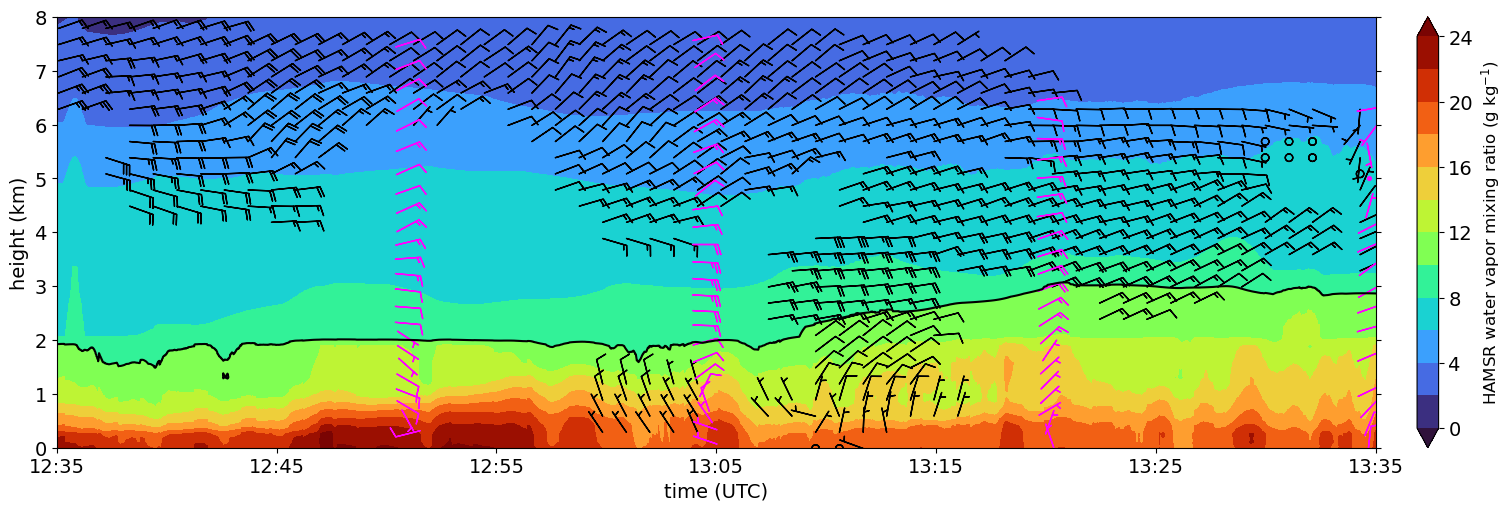

In [7]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(figWidth, 5), constrained_layout=True)

# Let's add theta-e from HAMSR
var = []
height = []
time = []
for fname in hamsr_file_list:
    ds = xr.open_dataset(fname)
    var.append(ds.hamsr_airH2OMR[:,33])
    temp = ds.hamsr_airT[:,33]
    pres = ds.pressure[:,33]
    pres = pres.where(pres>1.0,other=np.nan)
    height.append(calculate_geometric_height(temp, pres))
    time.append(ds.time[:, 33])
# concatenate and do a rolling mean
varComplete = xr.concat(var, dim='lines').rolling(lines=30, center=True, min_periods=1).mean()
heightComplete = xr.concat(height, dim='lines').rolling(lines=30, center=True, min_periods=1).mean()
timeComplete = xr.concat(time, dim='lines')

[time2d, dum] = np.meshgrid(timeComplete, heightComplete[0,:])
im=ax.contourf(time2d,heightComplete.T*1.0e-3,varComplete.T,cmap='turbo',levels=np.arange(0,26,2),extend='both')
ax.contour(time2d,heightComplete.T*1.0e-3,varComplete.T,colors='k',levels=[10])

# Keep labels on the left
ax.yaxis.tick_left()

# Add empty ticks on the right side
# 'which' can be 'major', 'minor', or 'both'
# 'direction' can be 'in', 'out', or 'inout'
# 'labelbottom', 'labeltop', 'labelleft', 'labelright' control label visibility
# 'bottom', 'top', 'left', 'right' control tick visibility

ax.tick_params(
    axis='y',       # Apply to the y-axis
    which='both',   # Apply to both major and minor ticks
    left=True,      # Keep ticks on the left (where labels are)
    right=True,     # Show ticks on the right
    labelleft=True, # Show labels on the left
    labelright=False # Do NOT show labels on the right
)

# add colorbar
cb = plt.colorbar(im, pad=0.01)
cb.set_label("HAMSR water vapor mixing ratio (g kg$^{-1}$)", fontsize=12)
ax.set_ylim([0, 8])
ax.set_xlabel("time (UTC)")
ax.set_ylabel("height (km)")

# Format the x-axis to display datetime objects
ax.xaxis_date()

# # Define the interval for the x-axis tick labels (every 10 minutes)
interval = datetime.timedelta(minutes=10)
ax.xaxis.set_major_locator(
    mdates.MinuteLocator(interval=10)
)  # Or mdates.SecondLocator(interval=600)

# Format the date/time display on the x-axis
date_format = mdates.DateFormatter("%H:%M")  # Display hours and minutes
ax.xaxis.set_major_formatter(date_format)

fig.autofmt_xdate()  # Rotate date labels for better readability

# now add DAWN data
fname = pth + "cpexcv-DAWN_DC8_20220914_R0.nc"
dawnData = xr.open_dataset(fname).sel(time=slice(start_time, end_time))
# dawnData = xr.open_dataset(fname).sel(time=slice('2022-09-14 10:47','2022-09-14 11:25'))

[X, Y] = np.meshgrid(dawnData.time, dawnData.z)
plt.barbs(
    X[::10, ::2],
    Y[::10, ::2],
    dawnData.smoothed_U_comp.T[::10, ::2],
    dawnData.smoothed_V_comp.T[::10, ::2],
    length=6,
    barbcolor="k",
)

for fname in drop_file_list:
    # read dropsonde data as a data frame
    df = pd.read_csv(fname, skiprows=123)

    # eliminate points where there's no temp and no dew point
    df = df[
        (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Uwnd != -9999.0)
    ]
    # this is a trick to plot the dropsonde in place
    df["Time_Start_UTC"] = [
        pd.to_datetime("2022-09-14") + datetime.timedelta(seconds=df.Time_Start.iloc[0])
        for sec in df.Time_Start
    ]

    drop_skip = slice(None, None, 50)  # only plot every 100th value

    plt.barbs(
        pd.to_datetime(df["Time_Start_UTC"])[drop_skip],
        df["Altitude"][drop_skip] * 1e-3,
        df["Uwnd"][drop_skip],
        df["Vwnd"][drop_skip],
        fill_empty=True,
        length=6,
        pivot="middle",
        sizes=dict(emptybarb=0.075),
        barbcolor="magenta",
    )

plt.xlim(start_time, end_time)

fOut = "./Figures/curtainPlot_HAMSR_%s-%s.jpeg"% (start_time.strftime("%Y%m%d_%H%M"), end_time.strftime("%Y%m%d_%H%M"))
plt.savefig(
    fOut,
    bbox_inches="tight",
    dpi=300,
)

### Panels for the paper

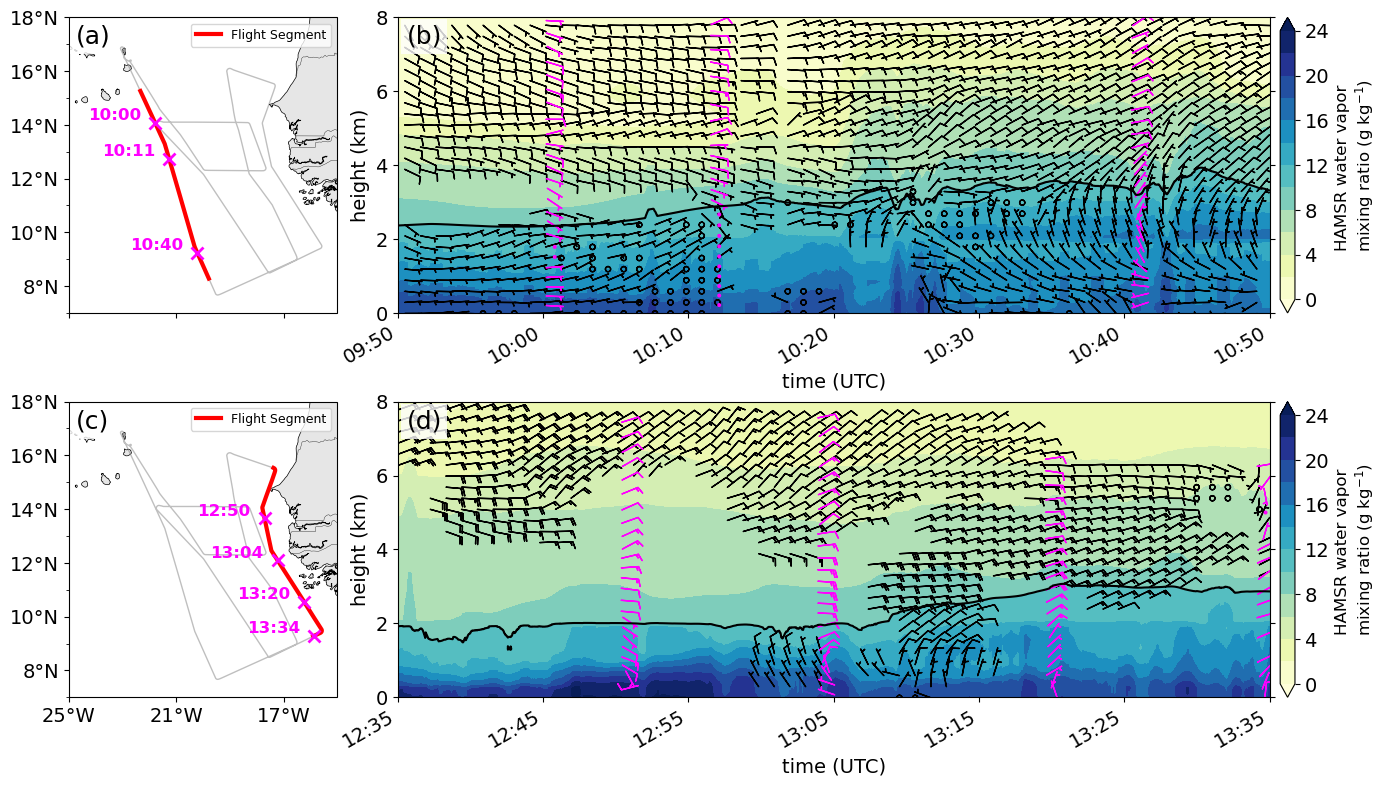

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import numpy as np
import pandas as pd
import datetime
import matplotlib.dates as mdates

# Load navigation data
file_date = "20220914"  # which date to create the APR plot for
# Function to convert seconds since midnight to datetime
def seconds_to_datetime(seconds):
    return base_date + datetime.timedelta(seconds=seconds)


# Define the date for which the seconds are counted
base_date = datetime.datetime(
    int(file_date[0:4]), int(file_date[4:6]), int(file_date[6:8])
)

# Read nav data
navFile = (
    "/glade/derecho/scratch/rberrios/projects/ongoing/cpex-cv/dataDC-8/CPEXCV-MetNav_DC8_%s_R0.ict"
    % file_date
)
dfNav = pd.read_csv(navFile, skiprows=75)

# Apply the function to the 'start_time' column to create a new 'start_datetime' column
dfNav["time_datetime"] = dfNav["Time_Start"].apply(seconds_to_datetime)


# --- REUSABLE PLOTTING FUNCTIONS ---

def plot_hamsr_panel(ax, start_time, end_time):

    # get list of hamsr files
    hamsr_file_list = find_hamsr_files(start_time, end_time)

    # get list of dropsonde files
    drop_file_list = find_dropsonde_files(start_time, end_time)
    
    # Let's collect the data from from HAMSR
    var = []
    height = []
    time = []
    for fname in hamsr_file_list:
        ds = xr.open_dataset(fname)
        var.append(ds.hamsr_airH2OMR[:,33])
        temp = ds.hamsr_airT[:,33]
        pres = ds.pressure[:,33]
        pres = pres.where(pres>1.0,other=np.nan)
        height.append(calculate_geometric_height(temp, pres))
        time.append(ds.time[:, 33])
    # concatenate and do a rolling mean
    varComplete = xr.concat(var, dim='lines').rolling(lines=30, center=True, min_periods=1).mean()
    heightComplete = xr.concat(height, dim='lines').rolling(lines=30, center=True, min_periods=1).mean()
    timeComplete = xr.concat(time, dim='lines')
    
    [time2d, dum] = np.meshgrid(timeComplete, heightComplete[0,:])
    im=ax.contourf(time2d,heightComplete.T*1.0e-3,varComplete.T,cmap='YlGnBu',levels=np.arange(0,26,2),extend='both')
    ax.contour(time2d,heightComplete.T*1.0e-3,varComplete.T,colors='k',levels=[10])
    
    # Keep labels on the left
    ax.yaxis.tick_left()
    
    # Add empty ticks on the right side
    # 'which' can be 'major', 'minor', or 'both'
    # 'direction' can be 'in', 'out', or 'inout'
    # 'labelbottom', 'labeltop', 'labelleft', 'labelright' control label visibility
    # 'bottom', 'top', 'left', 'right' control tick visibility
    
    ax.tick_params(
        axis='y',       # Apply to the y-axis
        which='both',   # Apply to both major and minor ticks
        left=True,      # Keep ticks on the left (where labels are)
        right=True,     # Show ticks on the right
        labelleft=True, # Show labels on the left
        labelright=False # Do NOT show labels on the right
    )
    
    # add colorbar
    cb = plt.colorbar(im, pad=0.01)
    cb.set_label("HAMSR water vapor \nmixing ratio (g kg$^{-1}$)", fontsize=12)
    ax.set_ylim([0, 8])
    ax.set_xlabel("time (UTC)")
    ax.set_ylabel("height (km)")
    
    # Format the x-axis to display datetime objects
    ax.xaxis_date()
    
    # # Define the interval for the x-axis tick labels (every 10 minutes)
    interval = datetime.timedelta(minutes=10)
    ax.xaxis.set_major_locator(
        mdates.MinuteLocator(interval=10)
    )  # Or mdates.SecondLocator(interval=600)
    
    # Format the date/time display on the x-axis
    date_format = mdates.DateFormatter("%H:%M")  # Display hours and minutes
    ax.xaxis.set_major_formatter(date_format)
    
    fig.autofmt_xdate()  # Rotate date labels for better readability
    
    # now add DAWN data
    fname = pth + "cpexcv-DAWN_DC8_20220914_R0.nc"
    dawnData = xr.open_dataset(fname).sel(time=slice(start_time, end_time))
    # dawnData = xr.open_dataset(fname).sel(time=slice('2022-09-14 10:47','2022-09-14 11:25'))
    
    [X, Y] = np.meshgrid(dawnData.time, dawnData.z)
    ax.barbs(
        X[::10, ::2],
        Y[::10, ::2],
        dawnData.smoothed_U_comp.T[::10, ::2],
        dawnData.smoothed_V_comp.T[::10, ::2],
        length=5,
        barbcolor="k",
    )
    
    for fname in drop_file_list:
        # read dropsonde data as a data frame
        df = pd.read_csv(fname, skiprows=123)
    
        # eliminate points where there's no temp and no dew point
        df = df[
            (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Uwnd != -9999.0)
        ]
        # this is a trick to plot the dropsonde in place
        df["Time_Start_UTC"] = [
            pd.to_datetime("2022-09-14") + datetime.timedelta(seconds=df.Time_Start.iloc[0])
            for sec in df.Time_Start
        ]
    
        drop_skip = slice(None, None, 50)  # only plot every 100th value
    
        ax.barbs(
            pd.to_datetime(df["Time_Start_UTC"])[drop_skip],
            df["Altitude"][drop_skip] * 1e-3,
            df["Uwnd"][drop_skip],
            df["Vwnd"][drop_skip],
            fill_empty=True,
            length=5,
            pivot="middle",
            sizes=dict(emptybarb=0.075),
            barbcolor="magenta",
        )
    
    ax.set_xlim(start_time, end_time)

def plot_map_panel(ax, dfNav, start, end):
    """Plots the flight track map for a specific window"""
    # 1. Map Features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.25)
    ax.add_feature(cfeature.LAND, facecolor="0.90")

    # 2. Set Extent & Ticks
    minLat, maxLat = 7, 18
    minLon, maxLon = -25, -15
    lat_interval, lon_interval = 2.0, 4.0
    
    ax.set_extent([minLon, maxLon, minLat, maxLat], ccrs.PlateCarree())
    
    # Ticks
    ax.set_yticks(np.arange(minLat, maxLat+0.1, lat_interval), ccrs.PlateCarree())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    
    ax.set_xticks(np.arange(minLon, maxLon+0.1, lon_interval), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))

    # 3. Plot Full Context Track (Gray)
    ax.plot(dfNav.Longitude, dfNav.Latitude, color="gray", linewidth=1, 
            transform=ccrs.PlateCarree(), alpha=0.5, label="_nolegend_")

    # 4. Plot Active Segment (Red)
    dfSub = dfNav[(dfNav.time_datetime >= start) & (dfNav.time_datetime <= end)]
    ax.plot(dfSub.Longitude, dfSub.Latitude, color="red", linewidth=3, 
            transform=ccrs.PlateCarree(), label="Flight Segment")

    # 5. Plot Dropsondes relevant to this window
    # Collect dropsonde files
    drop_file_list = find_dropsonde_files(start_time, end_time)
    
    # Simple check if drop time is within window (optional, or plot all)
    for fname in drop_file_list:
        # define label for this dropsonde
        label = fname[64:66] + ":" + fname[66:68]
    
        # read dropsonde data as a data frame
        df = pd.read_csv(fname, skiprows=123)
    
        # eliminate points where there's no temp and no dew point
        df = df[
            (df.Temperature != -9999.0) & (df.Dewpoint != -9999.0) & (df.Uwnd != -9999.0)
        ]

        ax.plot(df.Longitude.iloc[0], df.Latitude.iloc[0], "x", color="magenta", markersize=8, markeredgewidth=2, transform=ccrs.PlateCarree())
        ax.text(
            df.Longitude.iloc[0] - 2.5, df.Latitude.iloc[0] + 0.1, label, fontsize=12, color="magenta", weight='bold', transform=ccrs.PlateCarree()
        )
    
        drop = slice(None, None, 50)  # only plot every 100th value

    ax.legend(loc='upper right', fontsize=9)

# --- MAIN PLOTTING CONFIGURATION ---

# Figure setup: 2 rows (times), 3 columns (layout ratios)
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.1)

# --- first time ---
start_time0 = '20220914,095000'  #start date,time for the HAMSR plot
end_time0 = '20220914,105000'    #end date,time for the HAMSR plot
start_time = datetime.datetime.strptime(start_time0, '%Y%m%d,%H%M%S')
end_time = datetime.datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

# --- LEFT PANEL: HAMSR (Spans 3 Columns) ---
# This makes the HAMSR plot much wider (75% of width)
ax_h = fig.add_subplot(gs[0, 1:])
plot_hamsr_panel(ax_h, start_time, end_time)
# add panel label
ax_h.text(0.01, 0.975, '(b)', transform=ax_h.transAxes, 
              fontsize=18, va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# --- RIGHT PANEL: MAP (Spans 1 Column) ---
# This makes the Map container narrower (25% of width)
# This matches the "Tall and Narrow" shape of your map better, removing the side-padding
ax_m = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=0))
plot_map_panel(ax_m, dfNav, start_time, end_time)
# add panel label
ax_m.text(0.025, 0.975, '(a)', transform=ax_m.transAxes, 
              fontsize=18, va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# --- second time ---
start_time0 = '20220914,123500'  #start date,time for the HAMSR plot
end_time0 = '20220914,133500'    #end date,time for the HAMSR plot
start_time = datetime.datetime.strptime(start_time0, '%Y%m%d,%H%M%S')
end_time = datetime.datetime.strptime(end_time0, '%Y%m%d,%H%M%S')

# --- LEFT PANEL: HAMSR (Spans 3 Columns) ---
# This makes the HAMSR plot much wider (75% of width)
ax_h = fig.add_subplot(gs[1, 1:])
plot_hamsr_panel(ax_h, start_time, end_time)
# add panel label
ax_h.text(0.01, 0.975, '(d)', transform=ax_h.transAxes, 
              fontsize=18, va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# --- RIGHT PANEL: MAP (Spans 1 Column) ---
# This makes the Map container narrower (25% of width)
# This matches the "Tall and Narrow" shape of your map better, removing the side-padding
ax_m = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=0))
plot_map_panel(ax_m, dfNav, start_time, end_time)
ax_m.text(0.025, 0.975, '(c)', transform=ax_m.transAxes, 
              fontsize=18, va='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# =============================================================================
# SAVE & SHOW
# =============================================================================
# Generate a filename based on the first window start
timestamp = start_time.strftime("%Y%m%d")
fOut = f"./Figures/combined_HAMSR+drops+DAWN_maps_multi_panel_{timestamp}.jpeg"
plt.savefig(fOut, bbox_inches="tight", dpi=150)
plt.show()

### Checking some metadata and other variables

In [ ]:
ds

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
for fname in hamsr_file_list:
    ds = xr.open_dataset(fname)
    # var = (ds.Quality_flag[:,33])
    var = ds.hamsr_surf_rainrate_regression_180GHz[:,33].rolling(lines=30, center=True, min_periods=1).mean() # use 33 as the middle point for now
    time = ds.time[:,33]
    ax.plot(time,var,'-k') 

In [ ]:
ds.hamsr_surf_rainrate_regression_180GHz

In [ ]:
ds.time[:,33]